In [1]:
import numpy as np
import cv2
from pathlib import Path
import os
import pandas as pd
from skimage.feature import local_binary_pattern
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance
import shap
import joblib
import pandas as pd


In [2]:
import os
import cv2
from pathlib import Path

# Define paths
input_dir = '/kaggle/input/reef-support'
output_dir = '/kaggle/working/coral_dataset_resize'

# Target size
target_size = (512, 512)  # (width, height)

# Create output directories
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'masks_bleached'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'masks_non_bleached'), exist_ok=True)

# Get all image files from images subdirectory
images_dir = Path(input_dir) / 'images'
image_files = []
for ext in ['*.jpg', '*.JPG']:
    image_files.extend(images_dir.glob(ext))

print(f"Found {len(image_files)} images")

# Process each image
processed = 0
bleached_count = 0
non_bleached_count = 0
for img_path in image_files:
    img_name = img_path.stem
    
    # Read and resize image
    img = cv2.imread(str(img_path))
    if img is None:
        print(f"Warning: Could not read {img_path}")
        continue
    
    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Save resized image
    output_img_path = os.path.join(output_dir, 'images', f"{img_name}.jpg")
    cv2.imwrite(output_img_path, resized_img)
    
    # Process bleached mask if exists
    bleached_mask_path = Path(input_dir) / 'masks_bleached' / f"{img_name}_bleached.png"
    if bleached_mask_path.exists():
        mask = cv2.imread(str(bleached_mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
            output_mask_path = os.path.join(output_dir, 'masks_bleached', f"{img_name}_bleached.png")
            cv2.imwrite(output_mask_path, resized_mask)
            bleached_count += 1
    
    # Process non-bleached mask if exists
    non_bleached_mask_path = Path(input_dir) / 'masks_non_bleached' / f"{img_name}_non_bleached.png"
    if non_bleached_mask_path.exists():
        mask = cv2.imread(str(non_bleached_mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            resized_mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
            output_mask_path = os.path.join(output_dir, 'masks_non_bleached', f"{img_name}_non_bleached.png")
            cv2.imwrite(output_mask_path, resized_mask)
            non_bleached_count += 1
    
    processed += 1
    if processed % 100 == 0:
        print(f"Processed {processed}/{len(image_files)} images")

print(f"\nCompleted! Processed {processed} images")
print(f"Bleached masks: {bleached_count}")
print(f"Non-bleached masks: {non_bleached_count}")
print(f"Output saved to: {output_dir}")

Found 658 images
Processed 100/658 images
Processed 200/658 images
Processed 300/658 images
Processed 400/658 images
Processed 500/658 images
Processed 600/658 images

Completed! Processed 658 images
Bleached masks: 658
Non-bleached masks: 658
Output saved to: /kaggle/working/coral_dataset_resize


In [3]:
def extract_pixel_features(image, window_size=15):
    """
    Extract features for each pixel using local neighborhoods
    
    Args:
        image: RGB image (H, W, 3) - should be in 0-255 range (uint8)
        window_size: Size of local window around each pixel
        
    Returns:
        features: Array of shape (H*W, num_features)
    """
    # Ensure image is uint8 in 0-255 range
    if image.dtype != np.uint8:
        if image.max() <= 1.0:
            # If normalized (0-1), convert back to 0-255
            image = (image * 255).astype(np.uint8)
        else:
            # If float but already in 0-255 range
            image = image.astype(np.uint8)
    
    h, w = image.shape[:2]
    
    features_list = []
    
    # 1. RGB values at each pixel (3 features)
    rgb_features = image.reshape(-1, 3).astype(np.float32)  # Convert to float for consistency
    features_list.append(rgb_features)
    
    # 2. HSV values at each pixel (3 features)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_features = hsv.reshape(-1, 3).astype(np.float32)
    features_list.append(hsv_features)
    
    # 3. Local color statistics in neighborhood (6 features: mean & std for RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    for channel in range(3):
        ch = image[:, :, channel].astype(np.float32)
        
        # Local mean
        local_mean = cv2.blur(ch, (window_size, window_size))
        features_list.append(local_mean.reshape(-1, 1))
        
        # Local std (approximate)
        local_mean_sq = cv2.blur(ch**2, (window_size, window_size))
        local_std = np.sqrt(np.maximum(local_mean_sq - local_mean**2, 0))
        features_list.append(local_std.reshape(-1, 1))
    
    # 4. Local texture features
    # LBP (Local Binary Pattern) - captures local texture
    from skimage.feature import local_binary_pattern
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    features_list.append(lbp.reshape(-1, 1))
    
    # Local contrast (Laplacian)
    local_contrast = cv2.Laplacian(gray.astype(np.float32), cv2.CV_32F)
    features_list.append(np.abs(local_contrast).reshape(-1, 1))
    
    # 5. Edge strength at each pixel
    edges_x = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    edges_y = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    edge_magnitude = np.sqrt(edges_x**2 + edges_y**2)
    features_list.append(edge_magnitude.reshape(-1, 1))
    
    # 6. Local saturation statistics
    saturation = hsv[:, :, 1].astype(np.float32)
    local_sat_mean = cv2.blur(saturation, (window_size, window_size))
    features_list.append(local_sat_mean.reshape(-1, 1))
    
    # 7. Position features (normalized x, y)
    y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    features_list.append((x_coords / w).reshape(-1, 1))
    features_list.append((y_coords / h).reshape(-1, 1))
    
    # Concatenate all features
    features = np.hstack(features_list)
    
    return features

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm
import cv2
from PIL import Image

def parse_split_file(split_file_path):
    """
    Parse the dataset split text file to extract train/val/filtered image prefixes
    
    Args:
        split_file_path: Path to dataset_split.txt file
        
    Returns:
        Dictionary with 'train', 'val', and 'filtered' lists of image prefixes
    """
    with open(split_file_path, 'r') as f:
        lines = f.readlines()
    
    splits = {
        'train': [],
        'val': [],
        'filtered': []
    }
    
    current_section = None
    
    for line in lines:
        line = line.strip()
        
        # Skip empty lines and separator lines
        if not line or line.startswith('=') or line.startswith('-'):
            continue
        
        # Detect section headers
        if 'TRAINING SET' in line:
            current_section = 'train'
        elif 'VALIDATION SET' in line:
            current_section = 'val'
        elif 'FILTERED OUT' in line:
            current_section = 'filtered'
        elif current_section and not any(x in line for x in ['Total images', 'Random seed', 'Filter', 'Min coverage', 'images)']):
            # This is an image prefix line
            splits[current_section].append(line)
    
    return splits


def get_image_split_assignment(image_filename, split_prefixes):
    """
    Determine which split an image belongs to based on its filename
    
    Args:
        image_filename: Name of the image file (e.g., 'C10_BC_PM_T1_29nov24_CDaza_corr.jpg')
        split_prefixes: Dictionary from parse_split_file
        
    Returns:
        'train', 'val', 'filtered', or None if not found
    """
    # Remove file extension
    base_name = image_filename.replace('.jpg', '').replace('.JPG', '').replace('.png', '').replace('.PNG', '')
    
    # Check each split
    for split_name, prefixes in split_prefixes.items():
        for prefix in prefixes:
            if base_name.startswith(prefix):
                return split_name
    
    return None


def load_dataset_with_custom_split(data_dir, split_file_path, split='train', 
                                    max_images=None, sample_ratio=1.0, balance_classes=True):
    """
    Load non-normalized images (JPG) and extract features using custom split from text file
    
    Args:
        data_dir: Path to dataset directory containing images/masks_bleached/masks_non_bleached folders
        split_file_path: Path to dataset_split.txt file
        split: 'train' or 'val'
        max_images: Maximum number of images to load (None for all)
        sample_ratio: Ratio of pixels to sample per image (to manage memory)
        balance_classes: If True, undersample majority class to match minority class
        
    Returns:
        X: Feature array
        y: Label array
    """
    # Parse the split file
    split_prefixes = parse_split_file(split_file_path)
    print(f"\nSplit prefixes loaded:")
    print(f"  Train: {len(split_prefixes['train'])} prefixes")
    print(f"  Val: {len(split_prefixes['val'])} prefixes")
    print(f"  Filtered: {len(split_prefixes['filtered'])} prefixes")
    
    # Get all image files from the dataset
    data_path = Path(data_dir)
    images_dir = data_path / 'images'
    
    if not images_dir.exists():
        raise ValueError(f"Images directory not found: {images_dir}")
    
    # Get all JPG/PNG image files
    all_image_files = sorted([f for f in os.listdir(images_dir) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    if not all_image_files:
        raise ValueError(f"No .jpg/.png image files found in {images_dir}")
    
    print(f"\nTotal image files found: {len(all_image_files)}")
    
    # Filter images based on split assignment
    split_images = []
    for img_file in all_image_files:
        assignment = get_image_split_assignment(img_file, split_prefixes)
        if assignment == split:
            split_images.append(img_file)
    
    print(f"Images assigned to {split}: {len(split_images)}")
    
    if max_images:
        split_images = split_images[:max_images]
    
    X_list = []
    y_list = []
    
    print(f"\nLoading {split} data from {len(split_images)} images...")
    
    for img_file in tqdm(split_images):
        base_name = os.path.splitext(img_file)[0]
        
        # Construct paths
        img_path = data_path / 'images' / img_file
        bleach_path = data_path / 'masks_bleached' / f'{base_name}_bleached.png'
        healthy_path = data_path / 'masks_non_bleached' / f'{base_name}_non_bleached.png'
        
        try:
            # Load image (BGR -> RGB)
            image = cv2.imread(str(img_path))
            if image is None:
                print(f"Warning: Could not read image {img_path}, skipping...")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load masks
            bleach_mask = cv2.imread(str(bleach_path), cv2.IMREAD_GRAYSCALE)
            healthy_mask = cv2.imread(str(healthy_path), cv2.IMREAD_GRAYSCALE)
            
            if bleach_mask is None or healthy_mask is None:
                print(f"Warning: Could not read masks for {img_file}, skipping...")
                continue
            
            # Ensure masks are binary (0 or 1)
            bleach_mask = (bleach_mask > 127).astype(np.uint8)
            healthy_mask = (healthy_mask > 127).astype(np.uint8)
            
        except Exception as e:
            print(f"Warning: Could not load {img_file} - {e}, skipping...")
            continue
        
        # Create labels
        labels = np.zeros(image.shape[:2], dtype=np.int64)
        labels[healthy_mask == 1] = 1  # Healthy coral
        labels[bleach_mask == 1] = 2   # Bleached coral
        labels_flat = labels.reshape(-1)
        
        # Extract features
        features = extract_pixel_features(image, window_size=15)
        
        # Filter out background pixels (label 0)
        coral_mask = labels_flat > 0
        coral_features = features[coral_mask]
        coral_labels = labels_flat[coral_mask]
        
        # Balance classes if requested
        if balance_classes and len(coral_labels) > 0:
            healthy_idx = np.where(coral_labels == 1)[0]
            bleached_idx = np.where(coral_labels == 2)[0]
            
            if len(healthy_idx) > 0 and len(bleached_idx) > 0:
                n_minority = min(len(healthy_idx), len(bleached_idx))
                
                if len(healthy_idx) > len(bleached_idx):
                    healthy_sampled = np.random.choice(healthy_idx, n_minority, replace=False)
                    balanced_idx = np.concatenate([healthy_sampled, bleached_idx])
                else:
                    bleached_sampled = np.random.choice(bleached_idx, n_minority, replace=False)
                    balanced_idx = np.concatenate([healthy_idx, bleached_sampled])
                
                coral_features = coral_features[balanced_idx]
                coral_labels = coral_labels[balanced_idx]
        
        # Sample if needed
        elif sample_ratio < 1.0 and len(coral_labels) > 0:
            n_samples = int(len(coral_labels) * sample_ratio)
            indices = np.random.choice(len(coral_labels), n_samples, replace=False)
            coral_features = coral_features[indices]
            coral_labels = coral_labels[indices]
        
        X_list.append(coral_features)
        y_list.append(coral_labels)
    
    if not X_list:
        raise ValueError(f"No data loaded for {split} split!")
    
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    print(f"\nFinal {split} dataset:")
    print(f"  Healthy samples: {np.sum(y == 1):,}")
    print(f"  Bleached samples: {np.sum(y == 2):,}")
    
    return X, y


# Configuration
DATA_DIR = '/kaggle/working/coral_dataset_resize'
SPLIT_FILE = '/kaggle/input/coral-split/dataset_split.txt'
MAX_TRAIN_IMAGES = None  # Use all training images
MAX_VAL_IMAGES = None    # Use all validation images
SAMPLE_RATIO = 1.0       # Sample 100% of pixels per image

feature_names = [
    'R', 'G', 'B', 'H', 'S', 'V',
    'R_local_mean', 'R_local_std',
    'G_local_mean', 'G_local_std',
    'B_local_mean', 'B_local_std',
    'LBP', 'Local_contrast', 'Edge_magnitude',
    'Saturation_local_mean',
    'X_position', 'Y_position'
]



In [5]:
X_train, y_train = load_dataset_with_custom_split(
    DATA_DIR, 
    SPLIT_FILE, 
    split='train',
    max_images=MAX_TRAIN_IMAGES,
    sample_ratio=SAMPLE_RATIO,
    balance_classes=True
)

print(f"\nTraining data loaded:")
print(f"  Features shape: {X_train.shape}")
print(f"  Expected features: {len(feature_names)}")
print(f"  Labels shape: {y_train.shape}")
print(f"  Healthy pixels: {np.sum(y_train == 1):,}")
print(f"  Bleached pixels: {np.sum(y_train == 2):,}")


Split prefixes loaded:
  Train: 465 prefixes
  Val: 99 prefixes
  Filtered: 94 prefixes

Total image files found: 658
Images assigned to train: 465

Loading train data from 465 images...


100%|██████████| 465/465 [01:07<00:00,  6.91it/s]



Final train dataset:
  Healthy samples: 14,745,954
  Bleached samples: 9,088,758

Training data loaded:
  Features shape: (23834712, 18)
  Expected features: 18
  Labels shape: (23834712,)
  Healthy pixels: 14,745,954
  Bleached pixels: 9,088,758


In [6]:
def train_classifier(X_train, y_train, model):
    """
    Args:
        X_train: Training features
        y_train: Training labels
        model: Random Forest classifier
        
    Returns:
        Trained model
    """
    print(f"  Training samples: {len(X_train):,}")
    
    # Convert labels to binary (1: healthy -> 0, 2: bleached -> 1)
    y_binary = (y_train == 2).astype(int)
    
    # Calculate class distribution
    n_healthy = np.sum(y_binary == 0)
    n_bleached = np.sum(y_binary == 1)
    weight_ratio = n_healthy / n_bleached
    
    print(f"  Healthy samples: {n_healthy:,}")
    print(f"  Bleached samples: {n_bleached:,}")
    print(f"  Weight ratio: {weight_ratio:.2f}")
    
    # Set class weights for Random Forest
    class_weight = {0: 1.0, 1: weight_ratio}
    model.set_params(class_weight=class_weight)
    
    model.fit(X_train, y_binary)
    
    return model



In [7]:
n_estimators=10
max_depth=20
model = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    verbose=1
)

# Train model
model = train_classifier(X_train, y_train, model)

# Save model

joblib.dump(model, 'coral_bleaching_random_forest_gpu.pkl')
print("\nModel saved to 'coral_bleaching_random_forest_gpu.pkl'")



  Training samples: 23,834,712
  Healthy samples: 14,745,954
  Bleached samples: 9,088,758
  Weight ratio: 1.62


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.2min finished



Model saved to 'coral_bleaching_random_forest_gpu.pkl'


In [8]:
def load_segmentation_mask(img_filename, seg_dir):
    """
    Load pre-segmented coral mask (white=coral, black=background)
    
    Args:
        img_filename: Name of image file (e.g., 'C10_BC_PSb_T2_29nov24_HBenavides_corr.npy')
        seg_dir: Path to segmentation directory
        
    Returns:
        Binary mask (1=coral, 0=background) or None if not found
    """
    base_name = os.path.splitext(img_filename)[0]
    
    mask_name = f'{base_name}_coral_mask.png'
    mask_path = seg_dir / mask_name
    
    if mask_path.exists():
        mask_img = Image.open(mask_path).convert('L')  # Grayscale
        mask_array = np.array(mask_img)
        # Convert to binary (threshold at 128 to handle potential gray values)
        binary_mask = (mask_array > 128).astype(np.uint8)
        return binary_mask
    
    return None

In [9]:
import cv2
import numpy as np
from pathlib import Path
import os

rf_model = model
DATA_DIR = '/kaggle/working/coral_dataset_resize'  # Your resized dataset directory
SPLIT_FILE = '/kaggle/input/coral-split/dataset_split.txt'
SEGMENTATION_DIR = '/kaggle/input/val-segment/val_segmentation_outputs/binary_masks'

data_path = Path(DATA_DIR)
seg_path = Path(SEGMENTATION_DIR)

# Parse split file to get correct val images
split_prefixes = parse_split_file(SPLIT_FILE)
print(f"\nSplit prefixes loaded:")
print(f"  Train: {len(split_prefixes['train'])} prefixes")
print(f"  Val: {len(split_prefixes['val'])} prefixes")
print(f"  Filtered: {len(split_prefixes['filtered'])} prefixes")

# Get all image files from merged directory
images_dir = data_path / 'images'
if not images_dir.exists():
    raise ValueError(f"Images directory not found: {images_dir}")

# Look for JPG/PNG files instead of .npy
all_image_files = sorted([f for f in os.listdir(images_dir) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

if not all_image_files:
    raise ValueError(f"No .jpg/.png image files found in {images_dir}")

print(f"\nTotal image files found: {len(all_image_files)}")

# Filter to only val split images based on split assignment
val_images = []
for img_file in all_image_files:
    assignment = get_image_split_assignment(img_file, split_prefixes)
    if assignment == 'val':
        val_images.append(img_file)

print(f"\nVal images from split file: {len(val_images)}")
print(f"Total validation images: {len(val_images)}")


Split prefixes loaded:
  Train: 465 prefixes
  Val: 99 prefixes
  Filtered: 94 prefixes

Total image files found: 658

Val images from split file: 99
Total validation images: 99


In [10]:
import numpy as np
import cv2
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import joblib
from PIL import Image

all_accuracies = []
all_healthy_accuracies = []
all_bleached_accuracies = []
all_gt_healthy = []
all_gt_bleached = []
all_correct_healthy = []
all_correct_bleached = []
all_false_positives = []
all_false_negatives = []

# New metrics: pixel-level accuracy on ALL ground truth pixels
all_gt_healthy_total = []
all_gt_bleached_total = []
all_gt_healthy_segmented_and_correct = []
all_gt_bleached_segmented_and_correct = []
all_gt_healthy_not_segmented = []
all_gt_bleached_not_segmented = []

failed_images = []

for i in tqdm(range(len(val_images))):
    img_file = val_images[i]
    base_name = os.path.splitext(img_file)[0]
    
    # Direct paths (no subdirectories)
    sample_image_path = data_path / 'images' / img_file
    bleach_mask_path = data_path / 'masks_bleached' / f'{base_name}_bleached.png'
    healthy_mask_path = data_path / 'masks_non_bleached' / f'{base_name}_non_bleached.png'
    
    try:
        # Load image (JPG/PNG)
        image = cv2.imread(str(sample_image_path))
        if image is None:
            print(f"\n⚠️  {img_file}: Failed to load image")
            failed_images.append(img_file)
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load masks (PNG)
        bleach_mask = cv2.imread(str(bleach_mask_path), cv2.IMREAD_GRAYSCALE)
        healthy_mask = cv2.imread(str(healthy_mask_path), cv2.IMREAD_GRAYSCALE)
        
        if bleach_mask is None or healthy_mask is None:
            print(f"\n⚠️  {img_file}: Failed to load masks")
            failed_images.append(img_file)
            continue
        
        # Ensure masks are binary (0 or 1)
        bleach_mask = (bleach_mask > 127).astype(np.uint8)
        healthy_mask = (healthy_mask > 127).astype(np.uint8)
        
    except Exception as e:
        print(f"\n⚠️  {img_file}: Error - {e}")
        failed_images.append(img_file)
        continue
    
    h, w = image.shape[:2]
    
    # ========================================================================
    # STEP 1: Load EfficientNet segmentation mask
    # ========================================================================
    efficientnet_mask = load_segmentation_mask(img_file, seg_path)
    
    if efficientnet_mask is None:
        print(f"\n⚠️  {img_file}: Segmentation mask not found, skipping...")
        failed_images.append(img_file)
        continue
    
    # Ensure mask matches image dimensions
    if efficientnet_mask.shape[:2] != (h, w):
        efficientnet_mask = cv2.resize(efficientnet_mask, (w, h), interpolation=cv2.INTER_NEAREST)
    
    # ========================================================================
    # STEP 2: Extract features from EfficientNet-detected coral regions
    # ========================================================================
    all_features = extract_pixel_features(image, window_size=15)
    
    # Get pixels detected as coral by EfficientNet
    efficientnet_indices = efficientnet_mask.flatten() == 1
    n_efficientnet_coral = np.sum(efficientnet_indices)
    
    if n_efficientnet_coral == 0:
        print(f"\n⚠️  {img_file}: EfficientNet detected no coral pixels, skipping...")
        failed_images.append(img_file)
        continue
    
    efficientnet_features = all_features[efficientnet_indices]
    
    # ========================================================================
    # STEP 3: Apply Random Forest classification to EfficientNet regions
    # ========================================================================
    rf_predictions = rf_model.predict(efficientnet_features)  # 0=healthy, 1=bleached
    
    # Create prediction mask (0=background, 1=healthy, 2=bleached)
    pred_mask = np.zeros((h * w), dtype=int)
    pred_mask[efficientnet_indices] = rf_predictions + 1  # 0->1, 1->2
    pred_mask = pred_mask.reshape(h, w)
    
    # ========================================================================
    # STEP 4: Compute ground truth combined mask
    # ========================================================================
    gt_mask = np.zeros((h, w), dtype=int)
    gt_mask[healthy_mask == 1] = 1  # Healthy = 1
    gt_mask[bleach_mask == 1] = 2   # Bleached = 2
    
    # ========================================================================
    # STEP 5: Compare predictions vs ground truth (only on EfficientNet regions)
    # ========================================================================
    coral_region = efficientnet_mask == 1
    
    # Accuracy only on regions EfficientNet detected as coral
    correct = (pred_mask == gt_mask) & coral_region
    accuracy = np.sum(correct) / np.sum(coral_region) if np.sum(coral_region) > 0 else 0
    
    # Breakdown by class (within EfficientNet-detected regions)
    gt_healthy_in_region = (gt_mask == 1) & coral_region
    gt_bleached_in_region = (gt_mask == 2) & coral_region
    
    correct_healthy = np.sum((pred_mask == 1) & gt_healthy_in_region)
    correct_bleached = np.sum((pred_mask == 2) & gt_bleached_in_region)
    false_positives = np.sum((pred_mask == 2) & gt_healthy_in_region)
    false_negatives = np.sum((pred_mask == 1) & gt_bleached_in_region)
    
    n_gt_healthy = np.sum(gt_healthy_in_region)
    n_gt_bleached = np.sum(gt_bleached_in_region)
    
    healthy_acc = correct_healthy / n_gt_healthy if n_gt_healthy > 0 else 0
    bleached_acc = correct_bleached / n_gt_bleached if n_gt_bleached > 0 else 0
    
    # Store old metrics
    all_accuracies.append(accuracy)
    all_healthy_accuracies.append(healthy_acc)
    all_bleached_accuracies.append(bleached_acc)
    all_gt_healthy.append(n_gt_healthy)
    all_gt_bleached.append(n_gt_bleached)
    all_correct_healthy.append(correct_healthy)
    all_correct_bleached.append(correct_bleached)
    all_false_positives.append(false_positives)
    all_false_negatives.append(false_negatives)
    
    # ========================================================================
    # NEW: Pixel-level accuracy on ALL ground truth pixels
    # ========================================================================
    # Count total GT pixels
    gt_healthy_all = gt_mask == 1
    gt_bleached_all = gt_mask == 2
    
    n_gt_healthy_total = np.sum(gt_healthy_all)
    n_gt_bleached_total = np.sum(gt_bleached_all)
    
    # For each GT healthy pixel: is it segmented AND predicted as healthy?
    gt_healthy_segmented = gt_healthy_all & coral_region
    gt_healthy_segmented_and_correct = gt_healthy_segmented & (pred_mask == 1)
    n_gt_healthy_segmented_and_correct = np.sum(gt_healthy_segmented_and_correct)
    n_gt_healthy_not_segmented = n_gt_healthy_total - np.sum(gt_healthy_segmented)
    
    # For each GT bleached pixel: is it segmented AND predicted as bleached?
    gt_bleached_segmented = gt_bleached_all & coral_region
    gt_bleached_segmented_and_correct = gt_bleached_segmented & (pred_mask == 2)
    n_gt_bleached_segmented_and_correct = np.sum(gt_bleached_segmented_and_correct)
    n_gt_bleached_not_segmented = n_gt_bleached_total - np.sum(gt_bleached_segmented)
    
    # Store new metrics
    all_gt_healthy_total.append(n_gt_healthy_total)
    all_gt_bleached_total.append(n_gt_bleached_total)
    all_gt_healthy_segmented_and_correct.append(n_gt_healthy_segmented_and_correct)
    all_gt_bleached_segmented_and_correct.append(n_gt_bleached_segmented_and_correct)
    all_gt_healthy_not_segmented.append(n_gt_healthy_not_segmented)
    all_gt_bleached_not_segmented.append(n_gt_bleached_not_segmented)

# ============================================================================
# Print summary statistics
# ============================================================================
print(f"\n{'='*80}")
print(f"VALIDATION RESULTS SUMMARY")
print(f"{'='*80}")
print(f"Total validation images: {len(val_images)}")
print(f"Successfully processed: {len(all_accuracies)}")
print(f"Failed: {len(failed_images)}")

if all_accuracies:
    print(f"\n{'='*80}")
    print(f"METRICS ON SEGMENTED REGIONS ONLY (original)")
    print(f"{'='*80}")
    print(f"Overall Accuracy: {np.mean(all_accuracies):.4f} ± {np.std(all_accuracies):.4f}")
    print(f"Healthy Class Accuracy: {np.mean(all_healthy_accuracies):.4f} ± {np.std(all_healthy_accuracies):.4f}")
    print(f"Bleached Class Accuracy: {np.mean(all_bleached_accuracies):.4f} ± {np.std(all_bleached_accuracies):.4f}")
    
    total_gt_healthy = sum(all_gt_healthy)
    total_gt_bleached = sum(all_gt_bleached)
    total_correct_healthy = sum(all_correct_healthy)
    total_correct_bleached = sum(all_correct_bleached)
    total_fp = sum(all_false_positives)
    total_fn = sum(all_false_negatives)
    
    print(f"\nAggregated Metrics (across all images):")
    print(f"  Total Ground Truth Healthy Pixels (in segmented regions): {total_gt_healthy:,}")
    print(f"  Total Ground Truth Bleached Pixels (in segmented regions): {total_gt_bleached:,}")
    print(f"  Correctly Classified Healthy: {total_correct_healthy:,} ({total_correct_healthy/total_gt_healthy*100:.2f}%)")
    print(f"  Correctly Classified Bleached: {total_correct_bleached:,} ({total_correct_bleached/total_gt_bleached*100:.2f}%)")
    print(f"  False Positives (predicted bleached, actually healthy): {total_fp:,}")
    print(f"  False Negatives (predicted healthy, actually bleached): {total_fn:,}")
    
    print(f"\n{'='*80}")
    print(f"PIXEL-LEVEL ACCURACY ON ALL GROUND TRUTH PIXELS")
    print(f"{'='*80}")
    
    # Aggregate new metrics
    total_gt_healthy_all = sum(all_gt_healthy_total)
    total_gt_bleached_all = sum(all_gt_bleached_total)
    total_healthy_correct = sum(all_gt_healthy_segmented_and_correct)
    total_bleached_correct = sum(all_gt_bleached_segmented_and_correct)
    total_healthy_not_seg = sum(all_gt_healthy_not_segmented)
    total_bleached_not_seg = sum(all_gt_bleached_not_segmented)
    
    print(f"\nHEALTHY PIXELS:")
    print(f"  Total GT Healthy Pixels: {total_gt_healthy_all:,}")
    print(f"  Segmented AND Correctly Predicted as Healthy: {total_healthy_correct:,} ({total_healthy_correct/total_gt_healthy_all*100:.2f}%)")
    print(f"  Not Segmented (missed by EfficientNet): {total_healthy_not_seg:,} ({total_healthy_not_seg/total_gt_healthy_all*100:.2f}%)")
    print(f"  Segmented but Predicted Wrong: {total_gt_healthy_all - total_healthy_correct - total_healthy_not_seg:,}")
    
    print(f"\nBLEACHED PIXELS:")
    print(f"  Total GT Bleached Pixels: {total_gt_bleached_all:,}")
    print(f"  Segmented AND Correctly Predicted as Bleached: {total_bleached_correct:,} ({total_bleached_correct/total_gt_bleached_all*100:.2f}%)")
    print(f"  Not Segmented (missed by EfficientNet): {total_bleached_not_seg:,} ({total_bleached_not_seg/total_gt_bleached_all*100:.2f}%)")
    print(f"  Segmented but Predicted Wrong: {total_gt_bleached_all - total_bleached_correct - total_bleached_not_seg:,}")
    
    print(f"\n{'='*80}")
    print(f"OVERALL PIXEL-LEVEL ACCURACY:")
    total_gt_all = total_gt_healthy_all + total_gt_bleached_all
    total_correct_all = total_healthy_correct + total_bleached_correct
    print(f"  Accuracy: {total_correct_all:,} / {total_gt_all:,} = {total_correct_all/total_gt_all*100:.2f}%")
    print(f"  (This includes segmentation failures as incorrect)")
    print(f"{'='*80}")

if failed_images:
    print(f"\nFailed images ({len(failed_images)}):")
    for img in failed_images[:10]:  # Show first 10
        print(f"  - {img}")
    if len(failed_images) > 10:
        print(f"  ... and {len(failed_images) - 10} more")

  0%|          | 0/99 [00:00<?, ?it/s][Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
  1%|          | 1/99 [00:00<00:45,  2.15it/s][Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
  2%|▏         | 2/99 [00:00<00:32,  3.00it/s][Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
  3%|▎         | 3/99 [00:00<00:28,  3.38it/s][Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
  4%|▍         | 4/99 [00:01<00:28,  3.30it/s][Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.1s finished
  5%|▌         | 5/99 [00:01


VALIDATION RESULTS SUMMARY
Total validation images: 99
Successfully processed: 99
Failed: 0

METRICS ON SEGMENTED REGIONS ONLY (original)
Overall Accuracy: 0.5605 ± 0.2271
Healthy Class Accuracy: 0.7377 ± 0.2900
Bleached Class Accuracy: 0.6130 ± 0.3677

Aggregated Metrics (across all images):
  Total Ground Truth Healthy Pixels (in segmented regions): 4,637,383
  Total Ground Truth Bleached Pixels (in segmented regions): 3,428,019
  Correctly Classified Healthy: 3,695,484 (79.69%)
  Correctly Classified Bleached: 2,400,300 (70.02%)
  False Positives (predicted bleached, actually healthy): 941,899
  False Negatives (predicted healthy, actually bleached): 1,027,719

PIXEL-LEVEL ACCURACY ON ALL GROUND TRUTH PIXELS

HEALTHY PIXELS:
  Total GT Healthy Pixels: 6,059,570
  Segmented AND Correctly Predicted as Healthy: 3,695,484 (60.99%)
  Not Segmented (missed by EfficientNet): 1,422,187 (23.47%)
  Segmented but Predicted Wrong: 941,899

BLEACHED PIXELS:
  Total GT Bleached Pixels: 3,489,661

In [11]:

if all_accuracies:
    from sklearn.metrics import classification_report, confusion_matrix
    
    print(f"\n\n{'='*80}")
    print(f"AGGREGATE METRICS ({len(all_accuracies)} validation images)")
    print(f"{'='*80}")
    
    # Collect all predictions and ground truth across all images
    all_predictions = []
    all_ground_truth = []
    
    for i in range(len(all_gt_healthy)):
        # Recreate predictions and GT for this image
        n_correct_healthy = all_correct_healthy[i]
        n_fp = all_false_positives[i]
        n_correct_bleached = all_correct_bleached[i]
        n_fn = all_false_negatives[i]
        
        # Healthy predictions
        all_predictions.extend([0] * (n_correct_healthy + n_fn))  # 0 = healthy
        all_ground_truth.extend([0] * n_correct_healthy + [1] * n_fn)
        
        # Bleached predictions
        all_predictions.extend([1] * (n_correct_bleached + n_fp))  # 1 = bleached
        all_ground_truth.extend([1] * n_correct_bleached + [0] * n_fp)
    
    all_predictions = np.array(all_predictions)
    all_ground_truth = np.array(all_ground_truth)
    
    # Confusion matrix
    cm = confusion_matrix(all_ground_truth, all_predictions)
    
    print("\nCONFUSION MATRIX:")
    print(cm)
    print("\n")
    
    # Classification report
    print(classification_report(all_ground_truth, all_predictions, 
                                target_names=['Healthy', 'Bleached'],
                                digits=4))
    
    print(f"\n{'='*80}")
    print(f"DATA SUMMARY:")
    print(f"  Successfully processed: {len(all_accuracies)} images")
    print(f"  Failed to load: {len(failed_images)} images")
    if failed_images:
        print(f"    {failed_images}")
    print(f"{'='*80}")
else:
    print("\n❌ No images were successfully processed!")



AGGREGATE METRICS (99 validation images)

CONFUSION MATRIX:
[[3695484  941899]
 [1027719 2400300]]


              precision    recall  f1-score   support

     Healthy     0.7824    0.7969    0.7896   4637383
    Bleached     0.7182    0.7002    0.7091   3428019

    accuracy                         0.7558   8065402
   macro avg     0.7503    0.7485    0.7493   8065402
weighted avg     0.7551    0.7558    0.7554   8065402


DATA SUMMARY:
  Successfully processed: 99 images
  Failed to load: 0 images


Loading image and ground truth masks...
Image shape: (512, 512, 3)
Image range: [13, 250]

Segmentation stats:
  Coral pixels: 51,860
  Background pixels: 210,284

Extracting features from coral regions...
Features extracted shape: (51860, 18)

Applying Random Forest classification...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Random Forest Predictions (on coral regions):
  Predicted Healthy: 20,799 (40.11%)
  Predicted Bleached: 31,061 (59.89%)
  Mean bleaching probability: 0.6093

Comparing with ground truth...

Ground Truth (within EfficientNet regions):
  Healthy: 8,632
  Bleached: 36,145

Prediction Accuracy:
  ✓ Correctly Healthy: 8,568 (99.26%)
  ✓ Correctly Bleached: 29,612 (81.93%)
  ✗ False Positives (predicted bleached, actually healthy): 64
  ✗ False Negatives (predicted healthy, actually bleached): 6,533
  Overall Accuracy: 0.7362

Generating visualization...

✅ Visualization saved to 'single_image_prediction.png'


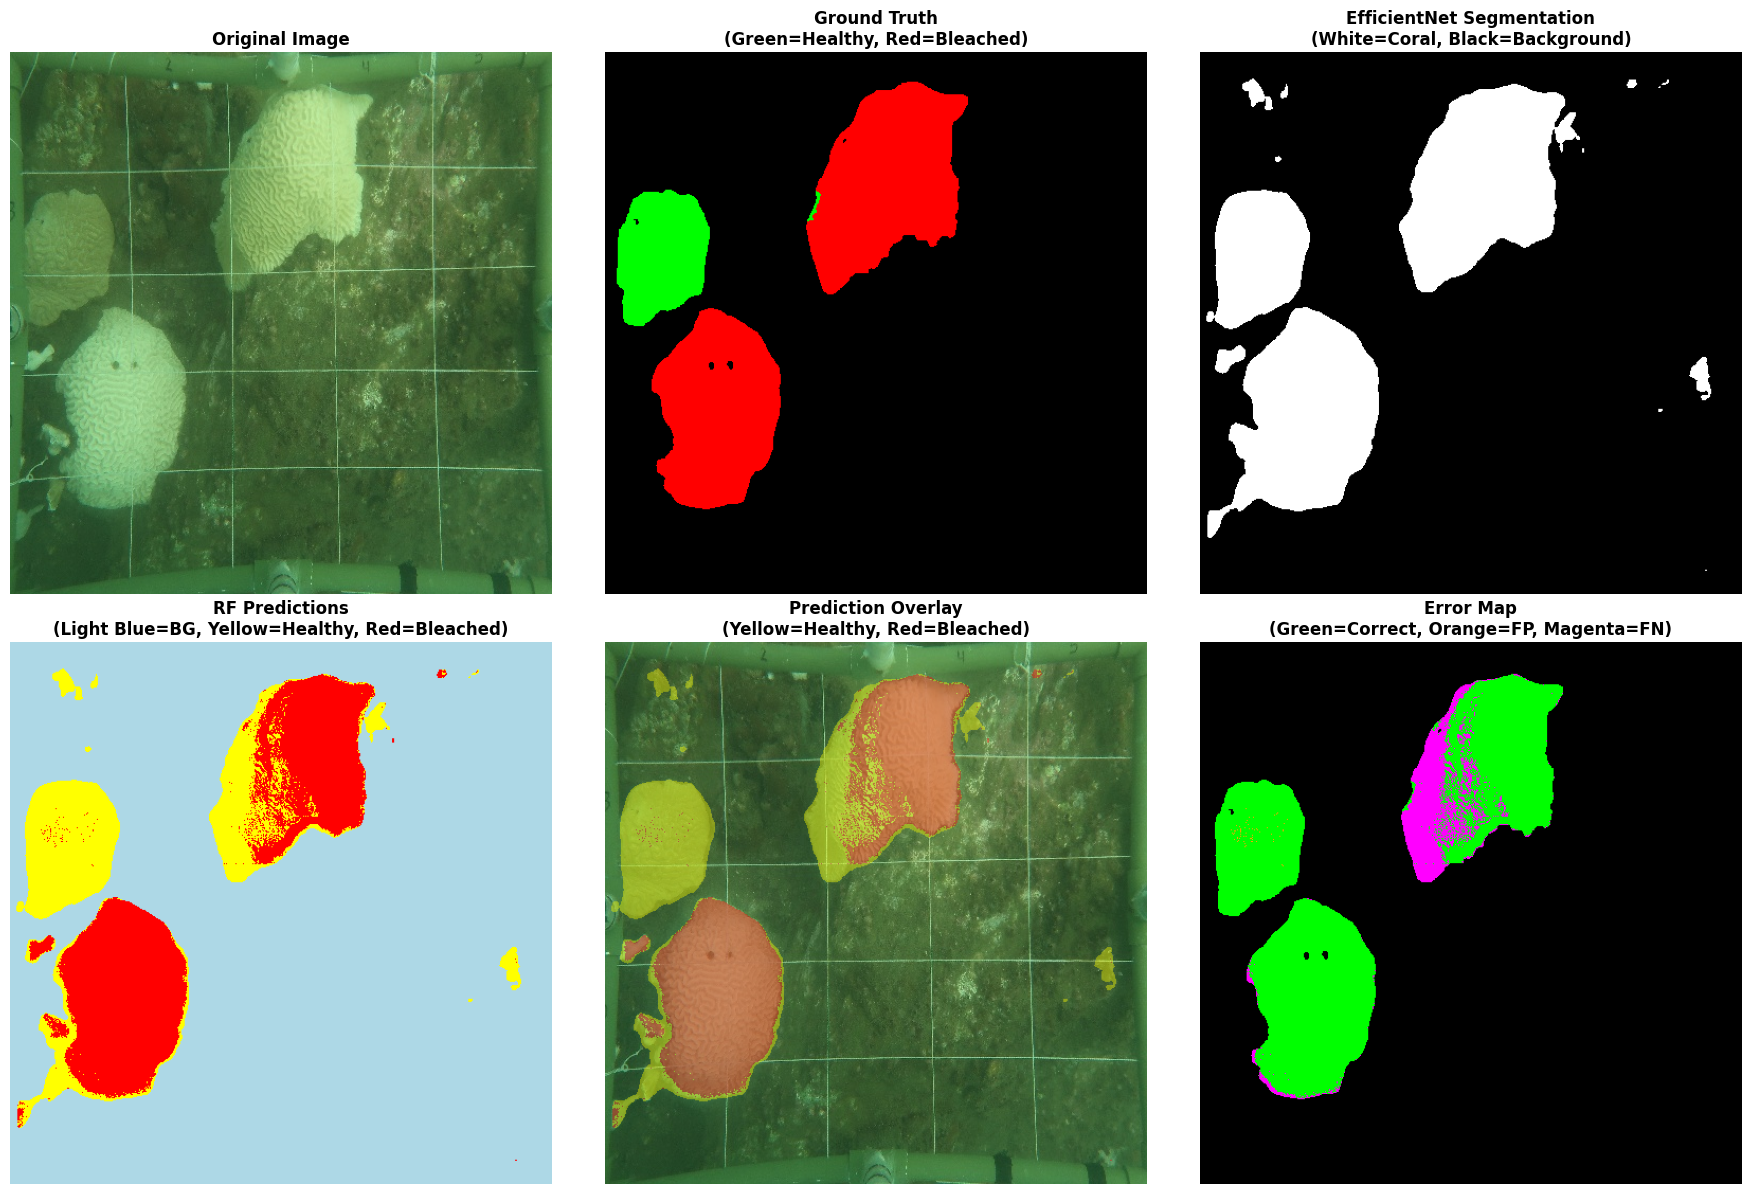

In [12]:
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import joblib
from PIL import Image

# ============================================================================
# Load models
# ============================================================================

rf_model = model  # Your trained model

# ============================================================================
# Configuration
# ============================================================================
sample_image_path = '/kaggle/working/coral_dataset_resize/images/C11_PB_PSb_T3_19nov24_HBenavides_Corr.jpg'
bleach_mask_path = '/kaggle/working/coral_dataset_resize/masks_bleached/C11_PB_PSb_T3_19nov24_HBenavides_Corr_bleached.png'
healthy_mask_path = '/kaggle/working/coral_dataset_resize/masks_non_bleached/C11_PB_PSb_T3_19nov24_HBenavides_Corr_non_bleached.png'
segmented_mask_path = '/kaggle/input/val-segment/val_segmentation_outputs/binary_masks/C11_PB_PSb_T3_19nov24_HBenavides_Corr_coral_mask.png'

# ============================================================================
# STEP 1: Load image and ground truth
# ============================================================================

print("Loading image and ground truth masks...")

# Load image (JPG)
image = cv2.imread(sample_image_path)
if image is None:
    raise ValueError(f"Could not load image from {sample_image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load masks (PNG)
bleach_mask = cv2.imread(bleach_mask_path, cv2.IMREAD_GRAYSCALE)
healthy_mask = cv2.imread(healthy_mask_path, cv2.IMREAD_GRAYSCALE)

if bleach_mask is None or healthy_mask is None:
    raise ValueError("Could not load masks")

# Ensure masks are binary (0 or 1)
bleach_mask = (bleach_mask > 127).astype(np.uint8)
healthy_mask = (healthy_mask > 127).astype(np.uint8)

h, w = image.shape[:2]

print(f"Image shape: {image.shape}")
print(f"Image range: [{image.min()}, {image.max()}]")

# ============================================================================
# STEP 2: Apply EfficientNet segmentation
# ============================================================================
efficientnet_mask = cv2.imread(segmented_mask_path, cv2.IMREAD_GRAYSCALE)

# Binarize it (assuming white = coral, black = background)
efficientnet_mask = (efficientnet_mask > 128).astype(np.uint8)

# Resize to match original image size if needed
if efficientnet_mask.shape != (h, w):
    efficientnet_mask = cv2.resize(efficientnet_mask, (w, h), interpolation=cv2.INTER_NEAREST)

n_coral_pixels = np.sum(efficientnet_mask == 1)
n_background_pixels = np.sum(efficientnet_mask == 0)

print(f"\nSegmentation stats:")
print(f"  Coral pixels: {n_coral_pixels:,}")
print(f"  Background pixels: {n_background_pixels:,}")

# ============================================================================
# STEP 3: Extract features from EfficientNet-detected regions
# ============================================================================

print("\nExtracting features from coral regions...")

# Extract features for all pixels (image is already uint8, 0-255)
all_features = extract_pixel_features(image, window_size=15)

# Get indices of coral pixels
coral_indices = efficientnet_mask.flatten() == 1
coral_features = all_features[coral_indices]

print(f"Features extracted shape: {coral_features.shape}")

# ============================================================================
# STEP 4: Apply Random Forest classification
# ============================================================================

print("\nApplying Random Forest classification...")

# Predict: 0=healthy, 1=bleached
rf_predictions = rf_model.predict(coral_features)
rf_probabilities = rf_model.predict_proba(coral_features)

# Create prediction mask (0=background, 1=healthy, 2=bleached)
pred_mask = np.zeros((h * w), dtype=int)
pred_mask[coral_indices] = rf_predictions + 1  # 0->1, 1->2
pred_mask = pred_mask.reshape(h, w)

n_predicted_healthy = np.sum(rf_predictions == 0)
n_predicted_bleached = np.sum(rf_predictions == 1)

print(f"Random Forest Predictions (on coral regions):")
print(f"  Predicted Healthy: {n_predicted_healthy:,} ({n_predicted_healthy/n_coral_pixels*100:.2f}%)")
print(f"  Predicted Bleached: {n_predicted_bleached:,} ({n_predicted_bleached/n_coral_pixels*100:.2f}%)")
print(f"  Mean bleaching probability: {rf_probabilities[:, 1].mean():.4f}")

# ============================================================================
# STEP 5: Compare with ground truth
# ============================================================================

print("\nComparing with ground truth...")

# Create ground truth mask
gt_mask = np.zeros((h, w), dtype=int)
gt_mask[healthy_mask == 1] = 1  # Healthy
gt_mask[bleach_mask == 1] = 2   # Bleached

# Calculate metrics only on EfficientNet-detected coral regions
coral_region = efficientnet_mask == 1

correct = (pred_mask == gt_mask) & coral_region
accuracy = np.sum(correct) / np.sum(coral_region) if np.sum(coral_region) > 0 else 0

# Breakdown by class
gt_healthy_in_region = (gt_mask == 1) & coral_region
gt_bleached_in_region = (gt_mask == 2) & coral_region

correct_healthy = np.sum((pred_mask == 1) & gt_healthy_in_region)
correct_bleached = np.sum((pred_mask == 2) & gt_bleached_in_region)
false_positives = np.sum((pred_mask == 2) & gt_healthy_in_region)
false_negatives = np.sum((pred_mask == 1) & gt_bleached_in_region)

n_gt_healthy = np.sum(gt_healthy_in_region)
n_gt_bleached = np.sum(gt_bleached_in_region)

healthy_acc = correct_healthy / n_gt_healthy if n_gt_healthy > 0 else 0
bleached_acc = correct_bleached / n_gt_bleached if n_gt_bleached > 0 else 0

print(f"\nGround Truth (within EfficientNet regions):")
print(f"  Healthy: {n_gt_healthy:,}")
print(f"  Bleached: {n_gt_bleached:,}")

print(f"\nPrediction Accuracy:")
print(f"  ✓ Correctly Healthy: {correct_healthy:,} ({healthy_acc:.2%})")
print(f"  ✓ Correctly Bleached: {correct_bleached:,} ({bleached_acc:.2%})")
print(f"  ✗ False Positives (predicted bleached, actually healthy): {false_positives:,}")
print(f"  ✗ False Negatives (predicted healthy, actually bleached): {false_negatives:,}")
print(f"  Overall Accuracy: {accuracy:.4f}")

# ============================================================================
# STEP 6: Visualize
# ============================================================================

print("\nGenerating visualization...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Original, Ground Truth, EfficientNet Mask
axes[0, 0].imshow(image)
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Ground truth combined
gt_colored = np.zeros((h, w, 3), dtype=np.uint8)
gt_colored[gt_mask == 1] = [0, 255, 0]      # Green = healthy
gt_colored[gt_mask == 2] = [255, 0, 0]      # Red = bleached
axes[0, 1].imshow(gt_colored)
axes[0, 1].set_title('Ground Truth\n(Green=Healthy, Red=Bleached)', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# EfficientNet segmentation
axes[0, 2].imshow(efficientnet_mask, cmap='gray')
axes[0, 2].set_title('EfficientNet Segmentation\n(White=Coral, Black=Background)', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: RF Predictions, Overlay, Error Map
# RF predictions
pred_colored = np.zeros((h, w, 3), dtype=np.uint8)
pred_colored[pred_mask == 0] = [173, 216, 230]  # Light blue = background
pred_colored[pred_mask == 1] = [255, 255, 0]    # Yellow = healthy
pred_colored[pred_mask == 2] = [255, 0, 0]      # Red = bleached
axes[1, 0].imshow(pred_colored)
axes[1, 0].set_title('RF Predictions\n(Light Blue=BG, Yellow=Healthy, Red=Bleached)', 
                     fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Overlay on original (image is already uint8, 0-255)
overlay_rgb = image.copy()
# Apply semi-transparent overlay
mask_overlay = overlay_rgb.copy()
mask_overlay[pred_mask == 1] = [255, 255, 0]      # Yellow for healthy
mask_overlay[pred_mask == 2] = [255, 0, 0]        # Red for bleached
overlay_rgb = cv2.addWeighted(overlay_rgb, 0.6, mask_overlay, 0.4, 0)

axes[1, 1].imshow(overlay_rgb)
axes[1, 1].set_title('Prediction Overlay\n(Yellow=Healthy, Red=Bleached)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

# Error map
error_map = np.zeros((h, w, 3), dtype=np.uint8)
error_map[correct] = [0, 255, 0]                              # Green = correct
error_map[(pred_mask == 2) & (gt_mask == 1) & coral_region] = [255, 165, 0]  # Orange = FP
error_map[(pred_mask == 1) & (gt_mask == 2) & coral_region] = [255, 0, 255]  # Magenta = FN
axes[1, 2].imshow(error_map)
axes[1, 2].set_title('Error Map\n(Green=Correct, Orange=FP, Magenta=FN)', 
                     fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('single_image_prediction.png', dpi=150, bbox_inches='tight')
print("\n✅ Visualization saved to 'single_image_prediction.png'")
plt.show()


PIXEL INSPECTION AT POSITION (99, 284)

Pixel RGB Value: [155 214 146]
EfficientNet Segmentation: CORAL

RF Classification:
  Prediction: Bleached
  Ground Truth: Bleached
  Match: ✓ YES

NEIGHBORHOOD VISUALIZATION

✅ Complete visualization saved to 'pixel_inspection_99_284.png'

Layout:
  Top-left:    Full image with pixel location marked (red crosshair + green zoom region)
  Top-middle:  Zoomed original at target pixel
  Top-right:   Zoomed predictions at target pixel
  Bottom-left: Zoomed ground truth at target pixel
  Bottom-mid:  Full image predictions with pixel marked (green crosshair)
  Bottom-right: Full image ground truth with pixel marked (blue crosshair)


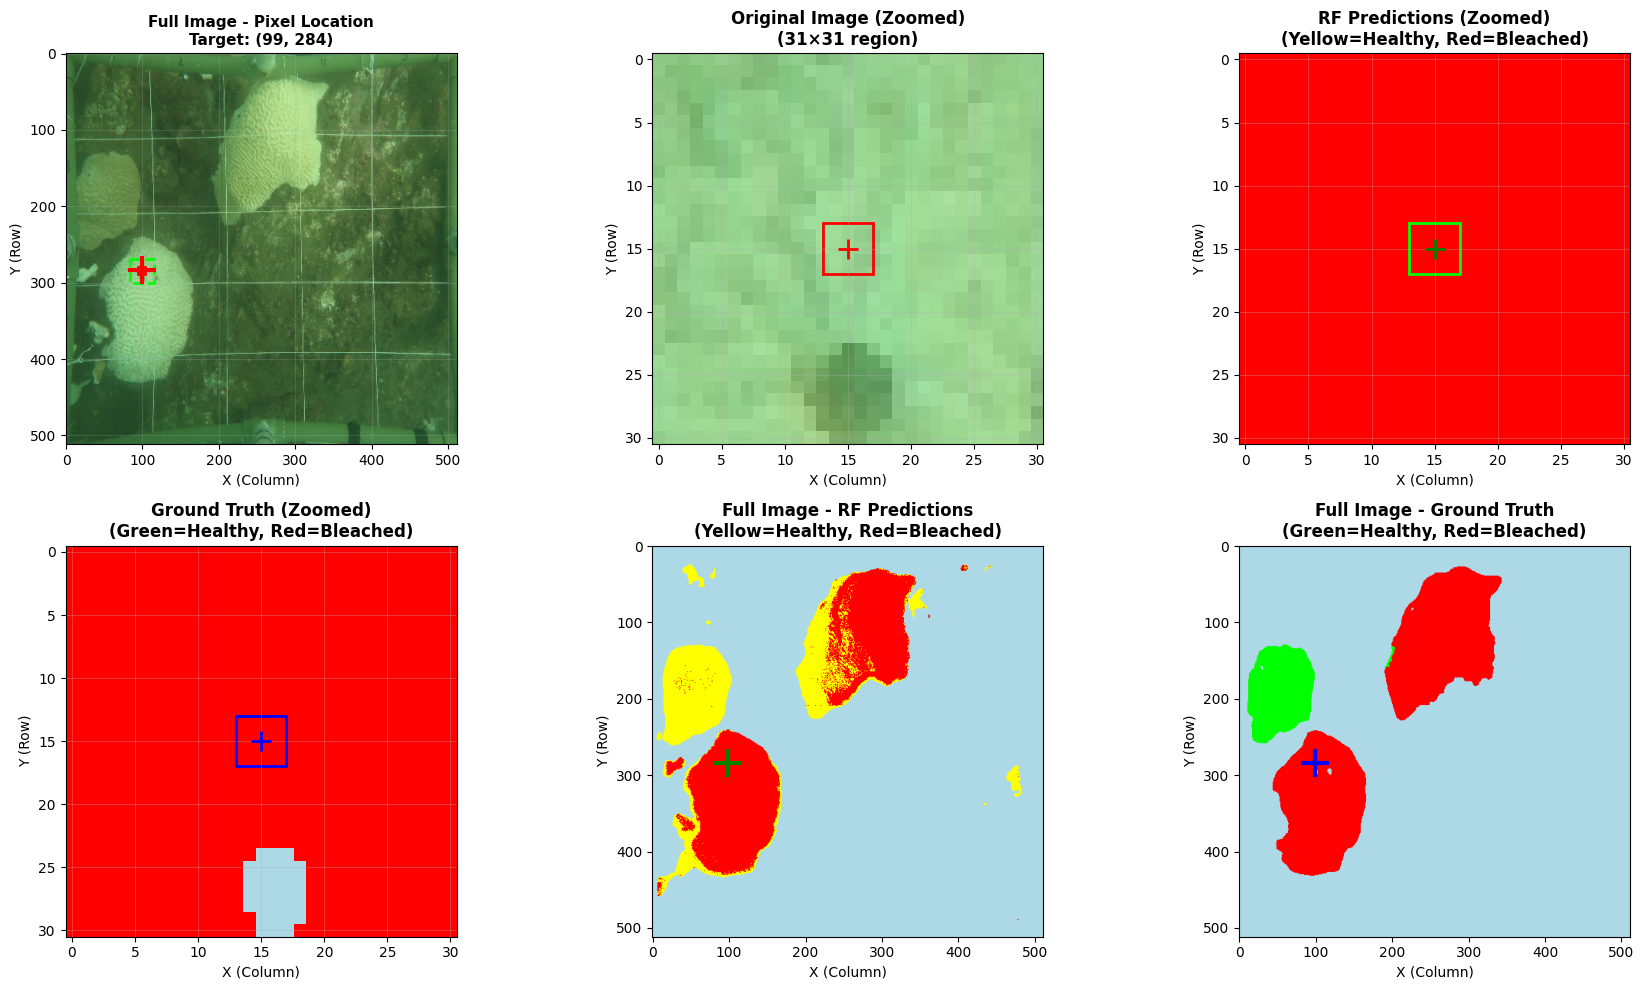

In [13]:
import numpy as np
import cv2
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

# Assuming you have already run the main script and have these variables:
# image, pred_mask, gt_mask, efficientnet_mask, rf_probabilities, coral_indices, rf_predictions

# ============================================================================
# INSPECT PREDICTION AT SPECIFIC POSITION
# ============================================================================

x, y = 99, 284  # Column, Row format

print(f"\n{'='*70}")
print(f"PIXEL INSPECTION AT POSITION ({x}, {y})")
print(f"{'='*70}")

# Check if position is within image bounds
if 0 <= y < h and 0 <= x < w:
    # Get pixel value
    pixel_rgb = image[y, x]
    print(f"\nPixel RGB Value: {pixel_rgb}")
    
    # Check segmentation
    is_coral = efficientnet_mask[y, x] == 1
    print(f"EfficientNet Segmentation: {'CORAL' if is_coral else 'BACKGROUND'}")
    
    if is_coral:
        # Get prediction
        pred_class = pred_mask[y, x]
        gt_class = gt_mask[y, x]
        
        pred_label = {0: 'Background', 1: 'Healthy', 2: 'Bleached'}
        gt_label = {0: 'Background', 1: 'Healthy', 2: 'Bleached'}
        
        print(f"\nRF Classification:")
        print(f"  Prediction: {pred_label[pred_class]}")
        print(f"  Ground Truth: {gt_label[gt_class]}")
        print(f"  Match: {'✓ YES' if pred_class == gt_class else '✗ NO'}")
        
        # Get probability
        flat_idx = y * w + x
        if flat_idx < len(rf_probabilities):
            prob_healthy = rf_probabilities[flat_idx, 0]
            prob_bleached = rf_probabilities[flat_idx, 1]
            print(f"\nClass Probabilities:")
            print(f"  P(Healthy):  {prob_healthy:.4f}")
            print(f"  P(Bleached): {prob_bleached:.4f}")
            print(f"  Confidence: {max(prob_healthy, prob_bleached):.4f}")
    else:
        print("This pixel is classified as BACKGROUND by EfficientNet")
        print("No RF prediction made for background pixels.")

else:
    print(f"Position ({x}, {y}) is outside image bounds (0-{w-1}, 0-{h-1})")

# ============================================================================
# VISUALIZE NEIGHBORHOOD AROUND PIXEL
# ============================================================================

print(f"\n{'='*70}")
print(f"NEIGHBORHOOD VISUALIZATION")
print(f"{'='*70}")

window_size = 31
half_win = window_size // 2

# Extract region
x1 = max(0, x - half_win)
x2 = min(w, x + half_win + 1)
y1 = max(0, y - half_win)
y2 = min(h, y + half_win + 1)

region_img = image[y1:y2, x1:x2].copy()
region_pred = pred_mask[y1:y2, x1:x2].copy()
region_gt = gt_mask[y1:y2, x1:x2].copy()

# Mark the target pixel location for zoom region calculations
mark_x = x - x1
mark_y = y - y1

# Create figure with subplots
fig = plt.figure(figsize=(18, 10))

# Row 0: Overview and zoomed views
# [0,0] Full image overview
ax1 = plt.subplot(2, 3, 1)
ax1.imshow(image)
ax1.plot(x, y, 'r+', markersize=20, markeredgewidth=3)
ax1.add_patch(Rectangle((x-5, y-5), 10, 10, fill=False, edgecolor='red', linewidth=2))
ax1.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='lime', linewidth=2, linestyle='--'))
ax1.set_title('Full Image - Pixel Location\nTarget: ({}, {})'.format(x, y), fontweight='bold', fontsize=11)
ax1.axis('on')
ax1.grid(True, alpha=0.2)
ax1.set_xlabel('X (Column)')
ax1.set_ylabel('Y (Row)')

# [0,1] Zoomed original
ax2 = plt.subplot(2, 3, 2)
ax2.imshow(region_img)
ax2.plot(mark_x, mark_y, 'r+', markersize=15, markeredgewidth=2)
ax2.add_patch(Rectangle((mark_x-2, mark_y-2), 4, 4, fill=False, edgecolor='red', linewidth=2))
ax2.set_title('Original Image (Zoomed)\n({}×{} region)'.format(window_size, window_size), fontweight='bold')
ax2.axis('on')
ax2.grid(True, alpha=0.3)
ax2.set_xlabel('X (Column)')
ax2.set_ylabel('Y (Row)')

# [0,2] Zoomed predictions
pred_colored = np.zeros((y2-y1, x2-x1, 3), dtype=np.uint8)
pred_colored[region_pred == 0] = [173, 216, 230]  # Light blue = background
pred_colored[region_pred == 1] = [255, 255, 0]    # Yellow = healthy
pred_colored[region_pred == 2] = [255, 0, 0]      # Red = bleached
ax3 = plt.subplot(2, 3, 3)
ax3.imshow(pred_colored)
ax3.plot(mark_x, mark_y, 'g+', markersize=15, markeredgewidth=2)
ax3.add_patch(Rectangle((mark_x-2, mark_y-2), 4, 4, fill=False, edgecolor='lime', linewidth=2))
ax3.set_title('RF Predictions (Zoomed)\n(Yellow=Healthy, Red=Bleached)', fontweight='bold')
ax3.axis('on')
ax3.grid(True, alpha=0.3)
ax3.set_xlabel('X (Column)')
ax3.set_ylabel('Y (Row)')

# Row 1: Full images
# [1,0] Zoomed ground truth
gt_colored = np.zeros((y2-y1, x2-x1, 3), dtype=np.uint8)
gt_colored[region_gt == 0] = [173, 216, 230]  # Light blue = background
gt_colored[region_gt == 1] = [0, 255, 0]      # Green = healthy
gt_colored[region_gt == 2] = [255, 0, 0]      # Red = bleached
ax4 = plt.subplot(2, 3, 4)
ax4.imshow(gt_colored)
ax4.plot(mark_x, mark_y, 'b+', markersize=15, markeredgewidth=2)
ax4.add_patch(Rectangle((mark_x-2, mark_y-2), 4, 4, fill=False, edgecolor='blue', linewidth=2))
ax4.set_title('Ground Truth (Zoomed)\n(Green=Healthy, Red=Bleached)', fontweight='bold')
ax4.axis('on')
ax4.grid(True, alpha=0.3)
ax4.set_xlabel('X (Column)')
ax4.set_ylabel('Y (Row)')

# [1,1] Full image predictions
pred_full = np.zeros((h, w, 3), dtype=np.uint8)
pred_full[pred_mask == 0] = [173, 216, 230]  # Light blue = background
pred_full[pred_mask == 1] = [255, 255, 0]    # Yellow = healthy
pred_full[pred_mask == 2] = [255, 0, 0]      # Red = bleached
ax5 = plt.subplot(2, 3, 5)
ax5.imshow(pred_full)
ax5.plot(x, y, 'g+', markersize=20, markeredgewidth=3)
ax5.set_title('Full Image - RF Predictions\n(Yellow=Healthy, Red=Bleached)', fontweight='bold')
ax5.axis('on')
ax5.set_xlabel('X (Column)')
ax5.set_ylabel('Y (Row)')

# [1,2] Full image ground truth
gt_full = np.zeros((h, w, 3), dtype=np.uint8)
gt_full[gt_mask == 0] = [173, 216, 230]  # Light blue = background
gt_full[gt_mask == 1] = [0, 255, 0]      # Green = healthy
gt_full[gt_mask == 2] = [255, 0, 0]      # Red = bleached
ax6 = plt.subplot(2, 3, 6)
ax6.imshow(gt_full)
ax6.plot(x, y, 'b+', markersize=20, markeredgewidth=3)
ax6.set_title('Full Image - Ground Truth\n(Green=Healthy, Red=Bleached)', fontweight='bold')
ax6.axis('on')
ax6.set_xlabel('X (Column)')
ax6.set_ylabel('Y (Row)')

plt.tight_layout()
plt.savefig('pixel_inspection_{}_{}.png'.format(x, y), dpi=150, bbox_inches='tight')
print("\n✅ Complete visualization saved to 'pixel_inspection_{}_{}.png'".format(x, y))
print("\nLayout:")
print("  Top-left:    Full image with pixel location marked (red crosshair + green zoom region)")
print("  Top-middle:  Zoomed original at target pixel")
print("  Top-right:   Zoomed predictions at target pixel")
print("  Bottom-left: Zoomed ground truth at target pixel")
print("  Bottom-mid:  Full image predictions with pixel marked (green crosshair)")
print("  Bottom-right: Full image ground truth with pixel marked (blue crosshair)")
plt.show()

In [14]:
# ============================================================================
# LIME EXPLANATION FOR THIS PIXEL
# ============================================================================
from lime.lime_tabular import LimeTabularExplainer

# 1️⃣ Prepare data used for the RF model
# Assuming you have 'X_train' and 'rf_model' available from training phase.
# If you only have feature data in memory, use that instead.
explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=['Healthy', 'Bleached'],
    mode='classification',
    discretize_continuous=True
)





LIME EXPLANATION: (99, 284)
Position: Row=284, Col=99
RGB: [155 214 146]
Ground Truth: Bleached

Prediction: Bleached (99.52%)
  Healthy: 0.48%
  Bleached: 99.52%
  Status: ✓ CORRECT

Top Features for 'Bleached':
  1. B_local_mean > 97.46: +0.1419 ↑
  2. G_local_mean > 139.94: +0.0745 ↑
  3. B > 101.00: +0.0397 ↑
  4. Saturation_local_mean <= 83.60: +0.0282 ↑
  5. X_position <= 0.28: +0.0229 ↑


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished



✅ Saved: lime_99_284.png


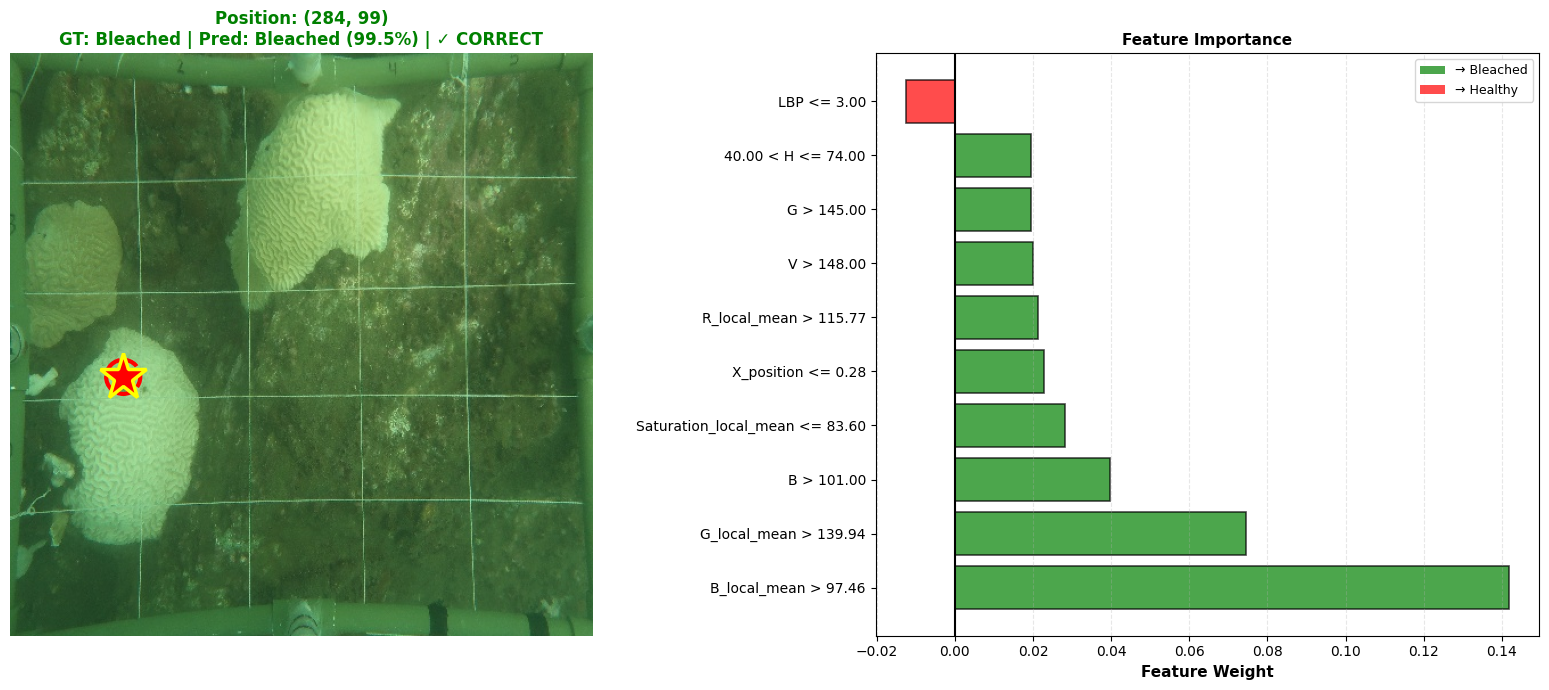

In [19]:
from matplotlib.patches import Circle
def explain_single_image_with_lime(x, y, image, gt_mask, rf_model, rf_probabilities, 
                                   rf_predictions, coral_indices, all_features, 
                                   feature_names, X_train, w, h, save_path=None):
    """
    Generate LIME explanation for a single pixel.
    
    Args:
        x, y: Pixel coordinates (column, row)
        image: Original RGB image
        gt_mask: Ground truth mask (1=Healthy, 2=Bleached)
        rf_model: Trained Random Forest model
        rf_probabilities: Model probabilities for all coral pixels
        rf_predictions: Model predictions for all coral pixels
        coral_indices: Boolean array indicating coral pixels
        all_features: Feature array for all pixels
        feature_names: List of feature names
        X_train: Training data for LIME
        w, h: Image width and height
        save_path: Path to save visualization (default: lime_{x}_{y}.png)
    
    Returns:
        dict: Explanation data with all relevant information
    """
    
    print(f"\n{'='*60}")
    print(f"LIME EXPLANATION: ({x}, {y})")
    print(f"{'='*60}")
    
    # Get indices
    flat_idx = y * w + x
    coral_pixel_idx = np.sum(coral_indices[:flat_idx])
    
    # Get pixel info
    pixel_features = all_features[flat_idx]
    pred_class = rf_predictions[coral_pixel_idx]  # 0=Healthy, 1=Bleached
    gt_class = gt_mask[y, x]  # 1=Healthy, 2=Bleached
    
    prob_h = rf_probabilities[coral_pixel_idx, 0]
    prob_b = rf_probabilities[coral_pixel_idx, 1]
    
    # Print info
    pred_label = ['Healthy', 'Bleached'][pred_class]
    gt_label = {1: 'Healthy', 2: 'Bleached'}.get(gt_class, 'Unknown')
    is_correct = (pred_class == gt_class - 1)
    
    print(f"Position: Row={y}, Col={x}")
    print(f"RGB: {image[y, x]}")
    print(f"Ground Truth: {gt_label}")
    print(f"\nPrediction: {pred_label} ({max(prob_h, prob_b)*100:.2f}%)")
    print(f"  Healthy: {prob_h*100:.2f}%")
    print(f"  Bleached: {prob_b*100:.2f}%")
    print(f"  Status: {'✓ CORRECT' if is_correct else '✗ INCORRECT'}")
    
    
    # Generate explanation
    explanation = explainer.explain_instance(
        data_row=pixel_features,
        predict_fn=rf_model.predict_proba,
        num_features=10
    )
    
    # Get feature list
    exp_list = explanation.as_list(label=pred_class)
    
    # Print top features
    print(f"\nTop Features for '{pred_label}':")
    for i, (feature, weight) in enumerate(exp_list[:5], 1):
        direction = "↑" if weight > 0 else "↓"
        print(f"  {i}. {feature}: {weight:+.4f} {direction}")
    
    # ========================================================================
    # VISUALIZE
    # ========================================================================
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Left: Image with pixel marked
    color = 'red' if pred_label == 'Bleached' else 'lime'
    axes[0].imshow(image)
    axes[0].plot(x, y, '*', color=color, markersize=35, 
                markeredgecolor='yellow', markeredgewidth=2.5)
    
    circle = Circle((x, y), 15, color=color, fill=False, 
                   linewidth=3, linestyle='--')
    axes[0].add_patch(circle)
    
    status_color = 'green' if is_correct else 'red'
    axes[0].set_title(
        f"Position: ({y}, {x})\n"
        f"GT: {gt_label} | Pred: {pred_label} ({max(prob_h, prob_b)*100:.1f}%) | "
        f"{'✓ CORRECT' if is_correct else '✗ INCORRECT'}",
        fontsize=12, fontweight='bold', color=status_color
    )
    axes[0].axis('off')
    
    # Right: Feature importance
    features = [item[0] for item in exp_list]
    weights = [item[1] for item in exp_list]
    colors_bar = ['green' if w > 0 else 'red' for w in weights]
    
    axes[1].barh(features, weights, color=colors_bar, alpha=0.7, 
               edgecolor='black', linewidth=1.2)
    axes[1].set_xlabel('Feature Weight', fontsize=11, fontweight='bold')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    axes[1].grid(axis='x', alpha=0.3, linestyle='--')
    axes[1].set_title("Feature Importance", fontsize=11, fontweight='bold')
    
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.7, label='→ Bleached'),
        Patch(facecolor='red', alpha=0.7, label='→ Healthy')
    ]
    axes[1].legend(handles=legend_elements, loc='best', fontsize=9)
    
    plt.tight_layout()
    
    if save_path is None:
        save_path = f'lime_{x}_{y}.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n{'='*60}")
    print(f"✅ Saved: {save_path}")
    print(f"{'='*60}")
    plt.show()
    
    # Return explanation data
    return {
        'position': (y, x),
        'rgb': image[y, x].tolist(),
        'gt_label': gt_label,
        'gt_class': gt_class,
        'pred_label': pred_label,
        'pred_class': pred_class,
        'proba': [prob_h, prob_b],
        'confidence': max(prob_h, prob_b),
        'is_correct': is_correct,
        'features': [item[0] for item in exp_list],
        'weights': [item[1] for item in exp_list],
        'explanation': explanation
    }


explanation_data = explain_single_image_with_lime(
    x=99, y=284,
    image=image,
    gt_mask=gt_mask,
    rf_model=rf_model,
    rf_probabilities=rf_probabilities,
    rf_predictions=rf_predictions,
    coral_indices=coral_indices,
    all_features=all_features,
    feature_names=feature_names,
    X_train=X_train,
    w=w, h=h
)


In [20]:
def explain_image_with_llm(explanation_data, api_key=None, 
                          model_name="llama-3.1-8b-instant",
                          base_url="https://api.groq.com/openai/v1"):
    """
    Generate natural language explanation using LLM.
    
    Args:
        explanation_data: Dictionary returned from explain_single_image_with_lime
        api_key: Groq API key
        model_name: Model to use (default: llama-3.1-8b-instant)
        base_url: API base URL
    
    Returns:
        tuple: (response, messages, client)
    """
    
    from openai import OpenAI
    
    client = OpenAI(
        api_key=api_key,
        base_url=base_url
    )
    
    # Extract data
    pos = explanation_data['position']
    gt_label = explanation_data['gt_label']
    pred_label = explanation_data['pred_label']
    confidence = explanation_data['confidence']
    probs = explanation_data['proba']
    features = explanation_data['features']
    weights = explanation_data['weights']
    
    # Build feature importance text
    feature_text = '\n'.join([f'"{feat}": {weight:.4f}' for feat, weight in zip(features, weights)])
    
    # Create prompt
    prompt = f'''You are a helpful assistant for explaining coral bleaching classification predictions at the pixel level.

Pixel Position: ({pos[0]}, {pos[1]})
Ground Truth: {gt_label}
Prediction: {pred_label}
Confidence: {confidence:.2%}
Probabilities: [Healthy={probs[0]:.2%}, Bleached={probs[1]:.2%}]

LIME feature importance scores (positive = supports Bleached, negative = supports Healthy):

{feature_text}

Please explain:
1. Why the model predicted this coral pixel as {pred_label}
2. Which features most influenced this decision
3. Whether the prediction matches the ground truth ({gt_label})
4. What the feature values and conditions mean for coral health

Use clear language suitable for marine biologists.'''
    
    print(f"\n{'='*60}")
    print(f"LLM EXPLANATION FOR PIXEL {pos}")
    print('='*60)
    
    messages = [
        {"role": "system", "content": "You are an expert ML explanation assistant specializing in coral bleaching classification using LIME explanations at the pixel level. Provide clear, accurate interpretations."},
        {"role": "user", "content": prompt}
    ]
    
    completion = client.chat.completions.create(
        messages=messages,
        temperature=0.2,
        model=model_name
    )
    
    response = completion.choices[0].message.content
    messages.append({"role": "assistant", "content": response})
    
    print(f"\n{response}\n")
    
    return response, messages, client
# Get LLM explanation using Groq
response, messages, client = explain_image_with_llm(
    explanation_data,
    api_key="",  # Your Groq key
    base_url="https://api.groq.com/openai/v1"
)


LLM EXPLANATION FOR PIXEL (284, 99)

**Explanation of Coral Bleaching Classification Prediction**

**1. Why the model predicted this coral pixel as Bleached:**

The model predicted this coral pixel as Bleached because it found a combination of features that are commonly associated with coral bleaching. The features that contributed to this decision are:

- The pixel's blue color intensity (B_local_mean > 97.46) is higher than expected for a healthy coral, which can be a sign of stress or damage.
- The pixel's green color intensity (G_local_mean > 139.94) is also higher than expected, which can be a sign of algae growth, a common cause of coral bleaching.
- The pixel's saturation level (Saturation_local_mean <= 83.60) is lower than expected, which can indicate a loss of pigmentation in the coral.

**2. Which features most influenced this decision:**

The feature that most influenced the decision is the blue color intensity (B_local_mean > 97.46), with a score of 0.1419. This suggests t